In [3]:
import sympy as sp
import numpy as np
import pandas as pd
import datetime as dt
from scipy.optimize import fsolve, minimize
import itertools
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression

from analyse import process_bonds

In [4]:
df = pd.read_csv('data/all_bonds_2023-08-02.csv')

df = process_bonds(df)

df = df.loc[df['bond_yield'].between(df['bond_yield'].quantile(0.05), df['bond_yield'].quantile(0.95))]
df = df[df['issuesize'] > 10000]
df['issuesize'] = df['issuesize'] / 10000


# df.to_csv('data/all_bonds_2023-08-02_processed.csv', index=False)

In [5]:
df = pd.read_csv('data/all_bonds_2023-08-02_processed.csv')

df['coupondates'] = df['coupondates'].map(eval)
df['coupon_maturities_years'] = df['coupon_maturities_years'].map(eval)


df = df[df['coupon_maturities_years'].apply(lambda x: (np.array(x) > 3).sum() == 0)]

df.head()

,name,is_traded,type,primary_boardid,couponpercent,couponfrequency,initialfacevalue,includedbymoex,issuesize,typename,...,waprice,accint,parsing_date,total_size_mil,coupon_percent_compounded,maturity_years,bond_yield,duration_years,dollar_duration,coupon_maturities_years
0,"""Российские ЖД"" ОАО 19 обл.",1,corporate_bond,TQCB,0.0785,2.0,1000.0,NaN,10000000.0,Корпоративная облигация,...,0.994170,4.73,2023-08-02,10000.0,0.079812,0.931507,0.083750,0.912665,907.344182,"[0.4328767123287671, 0.9315068493150684]"
2,"""Российские ЖД"" ОАО 23 обл.",1,corporate_bond,TQCB,0.0785,2.0,1000.0,NaN,15000000.0,Корпоративная облигация,...,0.983323,2.58,2023-08-02,15000.0,0.079812,1.457534,0.089234,1.401364,1377.993945,"[0.4602739726027397, 0.958904109589041, 1.4575..."
7,ПАО ОТКРЫТИЕ ФК Банк БО-03,1,exchange_bond,TQCB,0.0001,2.0,1000.0,NaN,18000000.0,Биржевая облигация,...,0.823036,0.00,2023-08-02,18000.0,0.000100,1.953425,0.099810,1.953256,1607.601022,"[0.4547945205479452, 0.9534246575342465, 1.457..."
9,РОСБАНК ПАО обл. БО-05,1,exchange_bond,TQCB,0.0675,2.0,1000.0,NaN,5000000.0,Биржевая облигация,...,1.000100,18.86,2023-08-02,5000.0,0.068825,0.216438,0.066982,0.216438,216.460000,[0.21643835616438356]
16,ПАО ОТКРЫТИЕ ФК Банк БО-02,1,exchange_bond,TQCB,0.0001,2.0,1000.0,NaN,24000000.0,Биржевая облигация,...,0.804125,0.04,2023-08-02,24000.0,0.000100,2.145205,0.101728,2.144913,1724.778383,"[0.14246575342465753, 0.6410958904109589, 1.14..."


In [6]:
def smooth_round(x):
    def custom_round(y, base=5):
        return int(base * round(float(y)/base))


    if x < 30:
        return custom_round(x, 10)
    elif x < 90:
        return custom_round(x, 20)
    elif x < 365:
        return custom_round(x, 30)
    elif x < 365 * 5:
        return custom_round(x, 60)
    else:
        return custom_round(x, 360)


maturities = (pd.Series(list(itertools.chain.from_iterable(df['coupon_maturities_years'].tolist()))) * 365).apply(smooth_round)

print(maturities.nunique())
# maturities.value_counts()

29


In [7]:
def get_row_impact(row):
    def get_symbol(day_in_years):
        return sp.symbols(
            names=f"y_{smooth_round(day_in_years * 365)}", 
            real=True, 
            # positive=True
        )


    yields = []
    coupon_cash_flows = 0
    for i in row['coupon_maturities_years']: 
        yields.append(get_symbol(i))
        coupon_cash_flows += row['couponvalue'] * sp.exp(-yields[-1]  * i)

    expr = coupon_cash_flows \
           + (row['facevalue'] * sp.exp(-yields[-1] * row['maturity_years'])) \
           - (row['facevalue'] * row['waprice']) \
           - (row['accint'])

    return yields, expr

In [8]:
yields = []
expression = 0
exprs = []
for _, row in tqdm(df.iterrows()):
    yields_batch, expr_batch = get_row_impact(row)
    yields += yields_batch
    exprs.append(expr_batch)
    expression += (expr_batch ** 2) * row['issuesize']

exprs = [i/1000 for i in exprs]
expression = expression / 1_000_000
yields = list(set(yields))

0it [00:00, ?it/s]

In [9]:
%%time

system_result_raw = sp.solvers.solvers.nsolve(exprs, 
                                   yields,
                                   np.ones(len(yields)) * 0.1,
                                   dict=True,
                                   modules=['mpmath'],
                                   prec=5,
                                   maxsteps=1000,
                                   tol=1_00_000)
 
 
system_result = pd.DataFrame(system_result_raw)\
    .T\
    .reset_index()\
    .rename({0: 'system_result'}, axis=1)

system_result['time'] = system_result['index'].astype(str).str[2:].astype(int)

system_result = system_result\
    .set_index('time')\
    .drop('index', axis=1)

system_result['system_result'] = system_result['system_result'].astype(float)

CPU times: user 18.8 s, sys: 44.4 ms, total: 18.8 s
Wall time: 18.9 s


In [10]:
%%time

lam_f = sp.lambdify([yields], expression)


function_result_raw = minimize(
    lam_f, 
    x0=np.ones(len(yields)) * 0.2, 
    bounds=((0.05, 0.2) for i in range(len(yields))),
    tol=0.0001
)['x']


function_result = pd.DataFrame([dict(zip([int(str(i)[2:]) for i in yields], function_result_raw))])\
    .T \
    .rename({0: 'function_result'}, axis=1)

function_result['function_result'] = function_result['function_result'].astype(float)

CPU times: user 4.88 s, sys: 6.03 ms, total: 4.89 s
Wall time: 4.9 s


In [11]:
general_result = pd.merge(system_result, 
                          function_result, 
                          left_index=True, 
                          right_index=True)

general_result = pd.merge(general_result, 
                          maturities.apply(smooth_round).value_counts(),
                          left_index=True, 
                          right_index=True)

general_result = general_result.sort_index()

general_result.head()

,system_result,function_result,count
0,20.337158,0.200000,50
10,0.128429,0.088007,77
20,0.399717,0.089456,71
40,0.158196,0.089726,187
60,0.098527,0.079428,134


<Axes: title={'center': "Raw results of zero-coupon bonds' yield"}, xlabel='days', ylabel='yield'>

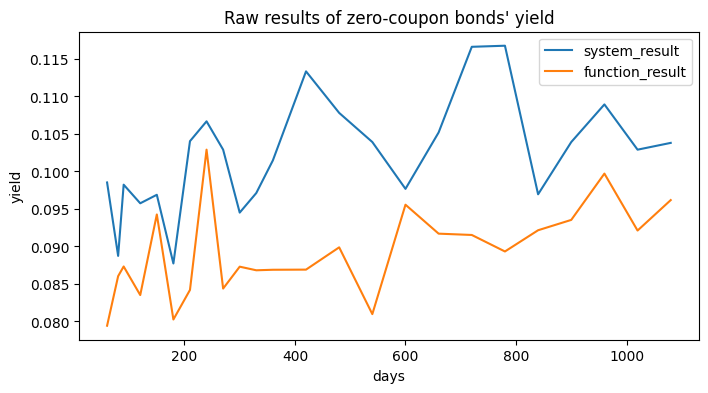

In [12]:
general_result\
    .loc[general_result.index>45, ['system_result', 'function_result']]\
    .plot(figsize=(8,4), title='Raw results of zero-coupon bonds\' yield', ylabel='yield', xlabel='days')

<Axes: title={'center': "Rolled results of zero-coupon bonds' yield"}, xlabel='days', ylabel='yield'>

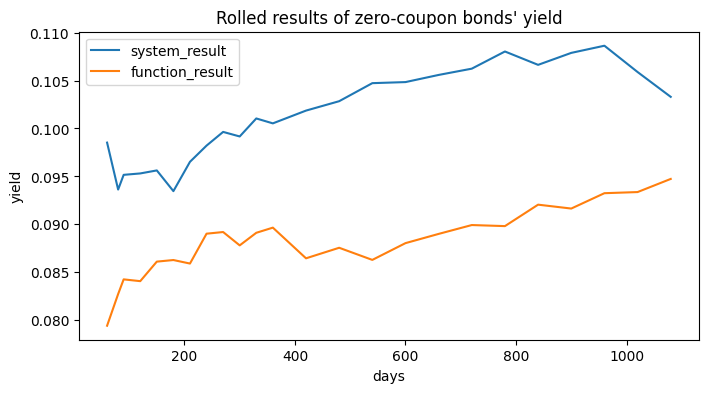

In [13]:
general_result\
    .loc[general_result.index>45, ['system_result', 'function_result']]\
    .rolling(window=5, min_periods=1, center=False)\
    .mean()\
    .plot(figsize=(8,4), title='Rolled results of zero-coupon bonds\' yield', ylabel='yield', xlabel='days')

<Axes: title={'center': "Rolled & avereged results of zero-coupon bonds' yield"}, xlabel='days', ylabel='yield'>

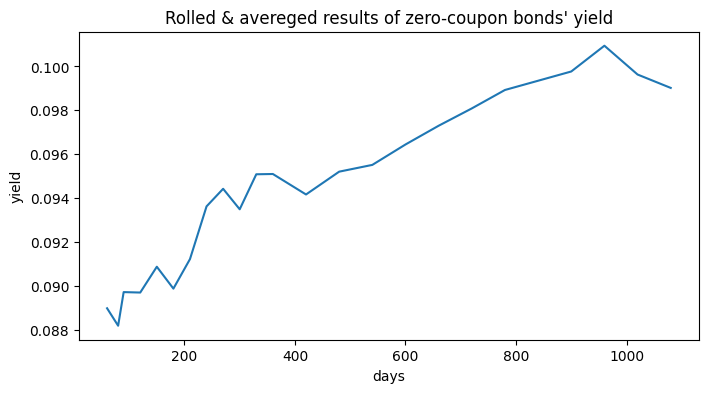

In [14]:
general_result\
    .loc[general_result.index>45, ['system_result', 'function_result']]\
    .mean(axis=1)\
    .rolling(window=5, min_periods=1, center=False)\
    .mean()\
    .plot(figsize=(8,4), title='Rolled & avereged results of zero-coupon bonds\' yield', ylabel='yield', xlabel='days')

/home/vlad/all/stack/fin_venv/lib64/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


<Axes: title={'center': "Bootstrapped & rolled & avereged results of zero-coupon bonds' yield"}, xlabel='days', ylabel='yield'>

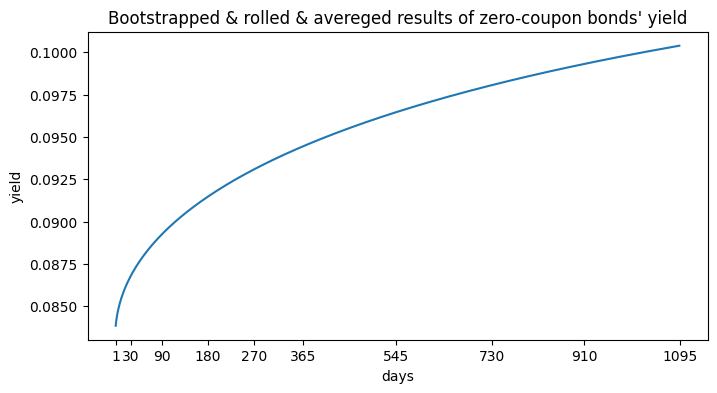

In [18]:
raw_result = general_result\
    .loc[general_result.index>45, ['system_result', 'function_result']]\
    .mean(axis=1)\
    .rolling(window=5, min_periods=1, center=False)\
    .mean()


X = raw_result.reset_index()['index'].agg([lambda x: x, lambda x: x ** (1/2)])
y = raw_result.values
reg = LinearRegression().fit(X, y)

timeframe = np.arange(1, 365*3)
end_result = reg.predict(pd.DataFrame([timeframe, timeframe ** (1/2)]).T)

pd.DataFrame(end_result, index=timeframe)\
    [0]\
    .plot(figsize=(8,4), 
          title='Bootstrapped & rolled & avereged results of zero-coupon bonds\' yield', 
          ylabel='yield', 
          xlabel='days', xticks=[1, 30, 90, 180, 270, 365, 365+180, 365* 2, 365*2 + 180, 365*3])